# Efficient Global Optimization method

by **Amal MACHTALAY** & **Abou CISSE**

## Imports

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import math
from scipy.optimize import minimize
from scipy.stats import norm

## Modified Branin function

$$f_{b}(x)=\left ( x_{2}-\frac{5.1}{4\pi^{2}}x_{1}^{2}+\frac{5}{\pi}x_{1}-6 \right )^{2}+10\left [ \left ( 1-\frac{1}{8\pi}\right )\cos x_{1}+1  \right ]+5x_{1} \quad , \quad x_{1}\in [-5,10], x_{2}\in [0,15]$$

We consider $x_{1}=15y_{1}-5$ and $x_{2}=15y_{2}$  

$$f_{b}(x)=f_{b}(15y_{1}-5,15y_{2}) \quad , \quad y_{1},y_{2} \in [0,1]$$

In [58]:
# for -5 <= x1 <= 10  and 0 <= x2 <= 15
c1=1-5.1/(4*np.pi**2)
c2=5/np.pi
c3=1-1/(8*np.pi)
def fb1(x1,x2):
    return ((x2*c1+x1*c2-6)**2+10*(c3*np.cos(x1)+1)+5*x1)

In [59]:
# for 0 <= y1, y2 <=1
def fb2(y1,y2):
    return fb1(15*y1-5,15*y2)

<a list of 68 text.Text objects>

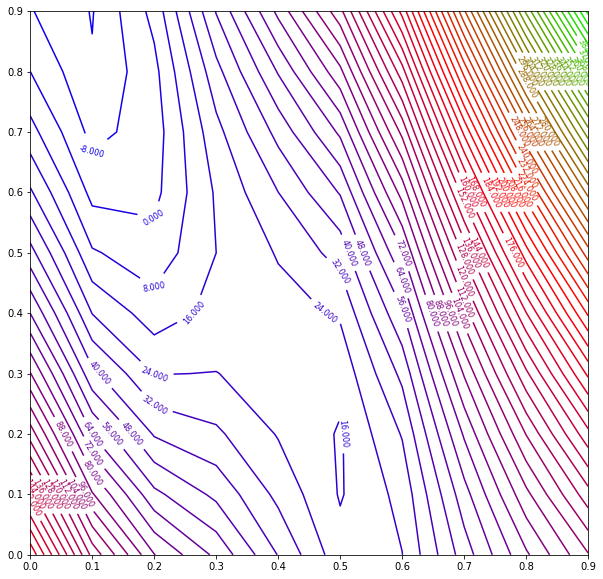

In [60]:
x=np.arange(0.0,1.0,0.1)
y=np.arange(0.0,1.0,0.1)
X,Y=np.meshgrid(x,y)
Z = fb2(X,Y)
#print(Z.shape)
#print(Z)
fig, ax =plt.subplots(figsize=(10,10))
ct=ax.contour(X,Y,Z, 60, cmap='brg')
plt.clabel(ct, inline=True, fontsize=8)

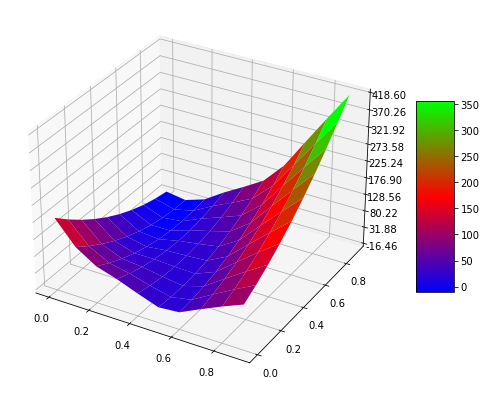

In [61]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='brg')

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

# Metamodeling

## 1. Code the functions Gaussian covariance and Univariate exponential

In [62]:
## 1 ##
# Gaussian covariance
def KG(x1,x2,theta,sigmma):
    return sigmma**2*math.exp(-np.linalg.norm(x1-x2)**2/theta**2)

# Univariate exponential
def KE(x1,x2,theta,sigmma):
    return sigmma**2*math.exp(-np.linalg.norm(x1-x2)/theta)

## 2. Génération des réalisations 1d

In [63]:
## 2 ##
def covariance_matrix1(N,t,theta,sigma):
    K=np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            K[i,j]=KG(t[i],t[j],theta,sigma)
    return K
N=5
t=np.linspace(0,1,5)
K=covariance_matrix1(N=5,t=t,theta=0.1,sigma=1)
#print(K)
mu=np.zeros(N)
gaussianvect=np.random.multivariate_normal(mu,K,1).T
print('gaussian-vector=\n',gaussianvect)

gaussian-vector=
 [[-0.55462823]
 [-0.19360959]
 [ 0.08896252]
 [-0.0510131 ]
 [ 1.12223811]]


**Note**
- $\sigma$ change the values of the diagonal of $K$.
- $\theta$ influence the singularity of the matrix $K$. $\theta$ should be small

## 3)  Implementation: function kvec and kmat

In [64]:
## 3 ##
def kvec(x,X):
  k=np.zeros(x.shape)
  for i in range(np.size(x)):
    k[i]=KG(x,X[:,i],0.1,1)
  return k
  #return np.array([KG(x,xj,thata, sig) for xj in X])

def kmat(X):
  k=np.zeros(X.shape)
  for i in range(X.shape[1]):
    k[i,:]=kvec(X[:,i],X)
  return k
  #return np.array([kvec(xi,X) for xi in X])

## 4) Design of experiments

xgrid= [0.  0.5 1. ]
Xgrid=
 [[0.  0. ]
 [0.  0.5]
 [0.  1. ]
 [0.5 0. ]
 [0.5 0.5]
 [0.5 1. ]
 [1.  0. ]
 [1.  0.5]
 [1.  1. ]]
Ygrid=
 [182.54246189  42.87860387 -11.474297    18.89228078  35.14733638
 136.71334914 150.26016806 322.43413729 579.91906368]


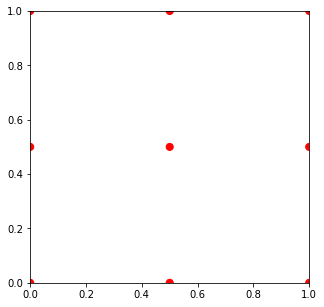

In [65]:
## 4 ##
ngrid=3
xgrid=np.linspace(0,1,ngrid)
Xgrid=np.array(np.meshgrid(xgrid,xgrid)).T.reshape(-1,2)
Ygrid=fb2(Xgrid[:,0],Xgrid[:,1])
print('xgrid=',xgrid)
print('Xgrid=\n',Xgrid)
print('Ygrid=\n',Ygrid)
size = [50,50,50,50,50,50,50,50,50]
n=9
plt.figure(figsize=[5,5])
plt.xlim([0,1]) 
plt.ylim([0,1]) 
plt.scatter(Xgrid[:,0], Xgrid[:,1], s=size, c='r') 

plt.show()

## 5.) Initial Model

In [66]:
## 5 ##
def covariance_matrix2(X1,X2,theta,sigma):
  n=len(X1)
  m=len(X2)
  K=np.zeros((n,m))
  i=0
  for x in X1:
    j=0
    for y in X2:
      K[i,j]=KG(x.T,y.T,theta,sigma)
      j+=1
    i+=1
  
  return K
ngrid=5
xgrid=np.linspace(0,1,ngrid)
DoE1=np.array(np.meshgrid(xgrid,xgrid)).T.reshape(-1,2)
Y1=fb2(DoE1[:,0],DoE1[:,1])
K1=covariance_matrix2(DoE1,DoE1,theta=0.2,sigma=1.0)
invK1=np.linalg.inv(K1+1e-6*np.eye(len(DoE1)))
Kv1=covariance_matrix2(Xgrid,DoE1,theta=0.2,sigma=1.0)
sigma2_hat1=(Y1.T.dot(invK1).dot(Y1))/len(Y1)
#predivtive mean
mn1=Kv1.dot(invK1).dot(Y1)
print('predivtive mean=\n',mn1)
#print('Exact mean=',Ygrid)
print()
#predictive variance
sn21 = sigma2_hat1*(1-np.diag(Kv1.dot(invK1).dot(Kv1.T)))
#print(sn21.shape)
print('predictive variance=\n',sn21)

predivtive mean=
 [182.54229887  42.87857349 -11.47428139  18.89227667  35.14732596
 136.71326602 150.26005594 322.4339213  579.91858354]

predictive variance=
 [0.02681825 0.02681825 0.02681825 0.02681825 0.02681825 0.02681825
 0.02681825 0.02681825 0.02681825]


## 6) Compare the result of the prediction with a Latin LHS hypercube of the same size

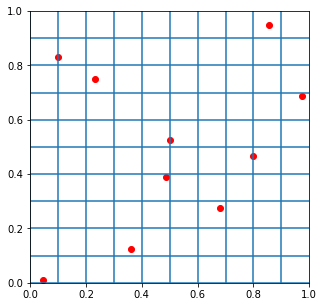

In [67]:
## 6 ##
def latin_hypercube_2d_uniform(n): 
    lower_limits = np.arange(0, n)/n 
    upper_limits = np.arange(1, n+1)/n 
    points = np.random.uniform(low=lower_limits, high=upper_limits, size=[2,n]).T 
    np.random.shuffle(points[:,1]) 
    return points 
n = 10
p = latin_hypercube_2d_uniform(n) 
#print(p) 
plt.figure(figsize=[5,5])
plt.xlim([0,1]) 
plt.ylim([0,1]) 
plt.scatter(p[:,0], p[:,1], c='r') 
for i in np.arange(0,1,1/n): 
    plt.axvline(i) 
    plt.axhline(i) 
plt.show()

In [68]:
N=9
DoE2=latin_hypercube_2d_uniform(N)
Y2= fb2(DoE2[:,0] , DoE2[:,1])
K2=covariance_matrix2(DoE2, DoE2, theta=0.2, sigma=1.0)
invK2=np.linalg.inv(K2+1e-6*np.eye(len(DoE2)))

Kv2=covariance_matrix2(Xgrid,DoE2,theta=0.2,sigma=1.0)
sigma2_hat2=(Y2.T.dot(invK2).dot(Y2))/len(Y2)
#predivtive mean
mn2=Kv2.dot(invK2).dot(Y2)
print('predivtive mean=\n',mn2)
#predictive variance
print()
sn22 = sigma2_hat2*(1-np.diag(Kv2.dot(invK2).dot(Kv2.T)))
print('predivtive variance=\n',sn22)


predivtive mean=
 [  3.15223952  20.4127128   -0.89359894  21.02932704  35.50014265
  37.9562583   49.15478747  28.67334372 168.24003426]

predivtive variance=
 [22099.60848091  9746.38666998 20930.82492036 19082.13422048
   342.54222052 21823.10148984 20707.57880404 21688.53250293
 17945.25689596]


### comparaison des résultat



In [69]:
RMSE1=np.sqrt(np.mean((Ygrid-mn1)**2))
RMSE2=np.sqrt(np.mean((Ygrid-mn2)**2))
print('RMSE1=',RMSE1)
print('RMSE2=',RMSE2)

RMSE1= 0.00018989207807650792
RMSE2= 185.15834029650085


## 7) log-likelihood to estimate θ, 

In [70]:
## 7  ##
def vraisemblance(theta, X, Y, eps):
    N=len(Y)
    K=covariance_matrix2(X, X, theta, 1.0) + eps*np.eye(N)
    invK= np.linalg.inv(K)
    (sign, logdetK)=np.linalg.slogdet(K)
    nuhat=(Y.T.dot(invK).dot(Y))/N
    return N*np.log(2*np.pi)/2 + N*np.log(nuhat)/2 + logdetK/2

# Optimisation
bnds=((0.001 , 1.0),)
res=minimize(vraisemblance,0.2, args=(DoE1, Y1, 1e-6,), bounds=bnds, method='L-BFGS-B')
teta_opt=res.x
print('theta_optimal=', teta_opt)

K3=covariance_matrix2(DoE2, DoE2, theta=teta_opt, sigma=1.0)
invK3=np.linalg.inv(K3+1e-6*np.eye(len(DoE2)))

Kv3=covariance_matrix2(Xgrid,DoE2,theta=teta_opt,sigma=1.)
sigma2_hat3=(Y2.T.dot(invK3).dot(Y2))/len(Y2)
#predivtive mean
mn3=Kv3.dot(invK3).dot(Y2)
#predictive variance
sn23 = sigma2_hat3*(1-Kv3.dot(invK3).dot(Kv3.T))
#print(sn23)


theta_optimal= [1.]


### compare to the previous result.

In [71]:
print('predivtive mean=\n',mn3)
print('predivtive variance=\n',sn23)

predivtive mean=
 [ 81.6052428   12.15377306 -76.55493863  44.74999932  35.89339783
 175.6353406  206.83153244 270.00634989 528.05819691]
predivtive variance=
 [[2.25211425e+03 2.59667528e+04 7.43520156e+04 2.57851573e+04
  4.63371038e+04 8.44489373e+04 7.46051795e+04 8.34725082e+04
  1.01661151e+05]
 [2.59667528e+04 9.47655659e+01 2.61208276e+04 4.64501010e+04
  2.60517505e+04 4.61202076e+04 8.40118393e+04 7.45776617e+04
  8.42066751e+04]
 [7.43520156e+04 2.61208276e+04 5.52413658e+02 8.41476926e+04
  4.63457463e+04 2.57906957e+04 1.02297831e+05 8.39729890e+04
  7.45880020e+04]
 [2.57851573e+04 4.64501010e+04 8.41476926e+04 2.25980274e+02
  2.60507026e+04 7.40789889e+04 2.60548926e+04 4.66658576e+04
  8.43767367e+04]
 [4.63371038e+04 2.60517505e+04 4.63457463e+04 2.60507026e+04
  2.78641532e-01 2.60622379e+04 4.63477282e+04 2.60487673e+04
  4.63361161e+04]
 [8.44489373e+04 4.61202076e+04 2.57906957e+04 7.40789889e+04
  2.60622379e+04 1.31713746e+03 8.41039195e+04 4.55453887e+04
  2.49

In [72]:

RMSE3=np.sqrt(np.mean((Ygrid-mn3)**2))
print('RMSE3=',RMSE3)

RMSE3= 53.94489846840498


# 2) EGO

## 1) The expected improvement function

In [84]:
## 1 ##
# The expected improvement function
def EI(theta,sigma2,invK,Xs,Ys):
    kvec=covariance_matrix2(Xgrid,Xs,theta=theta,sigma=1.0)
    mn=kvec.dot(invK).dot(Ys)
    sn2=sigma2*(1-kvec.dot(invK).dot(kvec.T))
    f_min=min(Ys)
    arg=(f_min-mn)/np.sqrt(sn2)
    res=(f_min-mn)*norm.cdf(arg)+np.sqrt(sn2)*norm.pdf(arg)
    return res  # this EI needs to be maximized

In [85]:
# Ploting EI
EIgrid = EI(theta=teta_opt,sigma2=sigma2_hat3,invK=invK3,Xs=DoE2,Ys=Y2)

EInew=np.zeros(9)
for i in range(9):
    EInew[i]=np.max(EIgrid[:,i])
print(EInew)


[ 89.28402864 108.26812114 167.63674935  93.49861253  67.76647654
  47.80990553  49.15481787  26.89567777   6.33025906]


## 2) The EGO_one_step function that maximizes the EI on the design domain.

In [86]:
def EGO_one_step(Xs,Ys):
    n=len(Ys)
    # optimize hyperparameters
    bandsVS=((0.001,1.0),)
    resVS=minimize(vraisemblance,0.2,args=(Xs,Ys,1e-6,),bounds=bandsVS,method='L-BFGS-B')
    theta=resVS.x
    # model fit
    K=covariance_matrix2(Xs,Xs,theta=1, sigma=1.0) # sigma estimated by plugin
    invK=np.linalg.inv(K+1e-6*np.eye(n))
    sigma2_hat=(Ys.T.dot(invK).dot(Ys))/n
    # Opitmization
    EIgrid = EI(theta=1,sigma2=sigma2_hat1,invK=invK,Xs=DoE1,Ys=Y1)
    EInew=np.zeros(9)
    for i in range(9):
        EInew[i]=np.max(EIgrid[:,i])
    return EInew
        


## 3) The performance on 21 steps (total budget of 30 evaluations).

In [87]:
X0=DoE1
Y0=Y1
print(EGO_one_step(X0,Y0))

[7.32534076e+00 3.22335330e+01 6.07421237e+01 4.12941558e+01
 2.18099017e+01 1.00350270e+01 1.12545810e+01 3.61511102e-01
 1.81285532e-03]


# Atterisseur lunaire 

# CODE

In [88]:

import sys, math
import numpy as np

import Box2D
from Box2D.b2 import (edgeShape, circleShape, fixtureDef, polygonShape, revoluteJointDef, contactListener)

import gym
from gym import spaces
from gym.utils import seeding, EzPickle

FPS = 50
SCALE = 30.0   # affects how fast-paced the game is, forces should be adjusted as well

MAIN_ENGINE_POWER = 13.0
SIDE_ENGINE_POWER = 0.6

INITIAL_RANDOM = 1500.0   # Set 1500 to make game harder

LANDER_POLY =[
    (-14, +17), (-17, 0), (-17 ,-10),
    (+17, -10), (+17, 0), (+14, +17)
    ]
LEG_AWAY = 20
LEG_DOWN = 18
LEG_W, LEG_H = 2, 8
LEG_SPRING_TORQUE = 40

SIDE_ENGINE_HEIGHT = 14.0
SIDE_ENGINE_AWAY = 12.0

VIEWPORT_W = 600
VIEWPORT_H = 400


class ContactDetector(contactListener):
    def __init__(self, env):
        contactListener.__init__(self)
        self.env = env

    def BeginContact(self, contact):
        if self.env.lander == contact.fixtureA.body or self.env.lander == contact.fixtureB.body:
            self.env.game_over = True
        for i in range(2):
            if self.env.legs[i] in [contact.fixtureA.body, contact.fixtureB.body]:
                self.env.legs[i].ground_contact = True

    def EndContact(self, contact):
        for i in range(2):
            if self.env.legs[i] in [contact.fixtureA.body, contact.fixtureB.body]:
                self.env.legs[i].ground_contact = False


class LunarLander(gym.Env, EzPickle):
    metadata = {
        'render.modes': ['human', 'rgb_array'],
        'video.frames_per_second' : FPS
    }

    continuous = False

    def __init__(self):
        EzPickle.__init__(self)
        self.seed()
        self.viewer = None

        self.world = Box2D.b2World()
        self.moon = None
        self.lander = None
        self.particles = []

        self.prev_reward = None

        # useful range is -1 .. +1, but spikes can be higher
        self.observation_space = spaces.Box(-np.inf, np.inf, shape=(8,), dtype=np.float32)

        if self.continuous:
            # Action is two floats [main engine, left-right engines].
            # Main engine: -1..0 off, 0..+1 throttle from 50% to 100% power. Engine can't work with less than 50% power.
            # Left-right:  -1.0..-0.5 fire left engine, +0.5..+1.0 fire right engine, -0.5..0.5 off
            self.action_space = spaces.Box(-1, +1, (2,), dtype=np.float32)
        else:
            # Nop, fire left engine, main engine, right engine
            self.action_space = spaces.Discrete(4)

        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def _destroy(self):
        if not self.moon: return
        self.world.contactListener = None
        self._clean_particles(True)
        self.world.DestroyBody(self.moon)
        self.moon = None
        self.world.DestroyBody(self.lander)
        self.lander = None
        self.world.DestroyBody(self.legs[0])
        self.world.DestroyBody(self.legs[1])

    def reset(self):
        self._destroy()
        self.world.contactListener_keepref = ContactDetector(self)
        self.world.contactListener = self.world.contactListener_keepref
        self.game_over = False
        self.prev_shaping = None

        W = VIEWPORT_W/SCALE
        H = VIEWPORT_H/SCALE

        # terrain
        CHUNKS = 11
        height = self.np_random.uniform(0, H/2, size=(CHUNKS+1,))
        chunk_x = [W/(CHUNKS-1)*i for i in range(CHUNKS)]
        self.helipad_x1 = chunk_x[CHUNKS//2-1]
        self.helipad_x2 = chunk_x[CHUNKS//2+1]
        self.helipad_y = H/4
        height[CHUNKS//2-2] = self.helipad_y
        height[CHUNKS//2-1] = self.helipad_y
        height[CHUNKS//2+0] = self.helipad_y
        height[CHUNKS//2+1] = self.helipad_y
        height[CHUNKS//2+2] = self.helipad_y
        smooth_y = [0.33*(height[i-1] + height[i+0] + height[i+1]) for i in range(CHUNKS)]

        self.moon = self.world.CreateStaticBody(shapes=edgeShape(vertices=[(0, 0), (W, 0)]))
        self.sky_polys = []
        for i in range(CHUNKS-1):
            p1 = (chunk_x[i], smooth_y[i])
            p2 = (chunk_x[i+1], smooth_y[i+1])
            self.moon.CreateEdgeFixture(
                vertices=[p1,p2],
                density=0,
                friction=0.1)
            self.sky_polys.append([p1, p2, (p2[0], H), (p1[0], H)])

        self.moon.color1 = (0.0, 0.0, 0.0)
        self.moon.color2 = (0.0, 0.0, 0.0)

        initial_y = VIEWPORT_H/SCALE
        self.lander = self.world.CreateDynamicBody(
            position=(VIEWPORT_W/SCALE/2, initial_y),
            angle=0.0,
            fixtures = fixtureDef(
                shape=polygonShape(vertices=[(x/SCALE, y/SCALE) for x, y in LANDER_POLY]),
                density=5.0,
                friction=0.1,
                categoryBits=0x0010,
                maskBits=0x001,   # collide only with ground
                restitution=0.0)  # 0.99 bouncy
                )
        self.lander.color1 = (0.5, 0.4, 0.9)
        self.lander.color2 = (0.3, 0.3, 0.5)
        self.lander.ApplyForceToCenter( (
            self.np_random.uniform(-INITIAL_RANDOM, INITIAL_RANDOM),
            self.np_random.uniform(-INITIAL_RANDOM, INITIAL_RANDOM)
            ), True)

        self.legs = []
        for i in [-1, +1]:
            leg = self.world.CreateDynamicBody(
                position=(VIEWPORT_W/SCALE/2 - i*LEG_AWAY/SCALE, initial_y),
                angle=(i * 0.05),
                fixtures=fixtureDef(
                    shape=polygonShape(box=(LEG_W/SCALE, LEG_H/SCALE)),
                    density=1.0,
                    restitution=0.0,
                    categoryBits=0x0020,
                    maskBits=0x001)
                )
            leg.ground_contact = False
            leg.color1 = (0.5, 0.4, 0.9)
            leg.color2 = (0.3, 0.3, 0.5)
            rjd = revoluteJointDef(
                bodyA=self.lander,
                bodyB=leg,
                localAnchorA=(0, 0),
                localAnchorB=(i * LEG_AWAY/SCALE, LEG_DOWN/SCALE),
                enableMotor=True,
                enableLimit=True,
                maxMotorTorque=LEG_SPRING_TORQUE,
                motorSpeed=+0.3 * i  # low enough not to jump back into the sky
                )
            if i == -1:
                rjd.lowerAngle = +0.9 - 0.5  # The most esoteric numbers here, angled legs have freedom to travel within
                rjd.upperAngle = +0.9
            else:
                rjd.lowerAngle = -0.9
                rjd.upperAngle = -0.9 + 0.5
            leg.joint = self.world.CreateJoint(rjd)
            self.legs.append(leg)

        self.drawlist = [self.lander] + self.legs

        return self.step(np.array([0, 0]) if self.continuous else 0)[0]

    def _create_particle(self, mass, x, y, ttl):
        p = self.world.CreateDynamicBody(
            position = (x, y),
            angle=0.0,
            fixtures = fixtureDef(
                shape=circleShape(radius=2/SCALE, pos=(0, 0)),
                density=mass,
                friction=0.1,
                categoryBits=0x0100,
                maskBits=0x001,  # collide only with ground
                restitution=0.3)
                )
        p.ttl = ttl
        self.particles.append(p)
        self._clean_particles(False)
        return p

    def _clean_particles(self, all):
        while self.particles and (all or self.particles[0].ttl < 0):
            self.world.DestroyBody(self.particles.pop(0))

    def step(self, action):
        if self.continuous:
            action = np.clip(action, -1, +1).astype(np.float32)
        else:
            assert self.action_space.contains(action), "%r (%s) invalid " % (action, type(action))

        # Engines
        tip  = (math.sin(self.lander.angle), math.cos(self.lander.angle))
        side = (-tip[1], tip[0])
        dispersion = [self.np_random.uniform(-1.0, +1.0) / SCALE for _ in range(2)]

        m_power = 0.0
        if (self.continuous and action[0] > 0.0) or (not self.continuous and action == 2):
            # Main engine
            if self.continuous:
                m_power = (np.clip(action[0], 0.0,1.0) + 1.0)*0.5   # 0.5..1.0
                assert m_power >= 0.5 and m_power <= 1.0
            else:
                m_power = 1.0
            ox = (tip[0] * (4/SCALE + 2 * dispersion[0]) +
                  side[0] * dispersion[1])  # 4 is move a bit downwards, +-2 for randomness
            oy = -tip[1] * (4/SCALE + 2 * dispersion[0]) - side[1] * dispersion[1]
            impulse_pos = (self.lander.position[0] + ox, self.lander.position[1] + oy)
            p = self._create_particle(3.5,  # 3.5 is here to make particle speed adequate
                                      impulse_pos[0],
                                      impulse_pos[1],
                                      m_power)  # particles are just a decoration
            p.ApplyLinearImpulse((ox * MAIN_ENGINE_POWER * m_power, oy * MAIN_ENGINE_POWER * m_power),
                                 impulse_pos,
                                 True)
            self.lander.ApplyLinearImpulse((-ox * MAIN_ENGINE_POWER * m_power, -oy * MAIN_ENGINE_POWER * m_power),
                                           impulse_pos,
                                           True)

        s_power = 0.0
        if (self.continuous and np.abs(action[1]) > 0.5) or (not self.continuous and action in [1, 3]):
            # Orientation engines
            if self.continuous:
                direction = np.sign(action[1])
                s_power = np.clip(np.abs(action[1]), 0.5, 1.0)
                assert s_power >= 0.5 and s_power <= 1.0
            else:
                direction = action-2
                s_power = 1.0
            ox = tip[0] * dispersion[0] + side[0] * (3 * dispersion[1] + direction * SIDE_ENGINE_AWAY/SCALE)
            oy = -tip[1] * dispersion[0] - side[1] * (3 * dispersion[1] + direction * SIDE_ENGINE_AWAY/SCALE)
            impulse_pos = (self.lander.position[0] + ox - tip[0] * 17/SCALE,
                           self.lander.position[1] + oy + tip[1] * SIDE_ENGINE_HEIGHT/SCALE)
            p = self._create_particle(0.7, impulse_pos[0], impulse_pos[1], s_power)
            p.ApplyLinearImpulse((ox * SIDE_ENGINE_POWER * s_power, oy * SIDE_ENGINE_POWER * s_power),
                                 impulse_pos
                                 , True)
            self.lander.ApplyLinearImpulse((-ox * SIDE_ENGINE_POWER * s_power, -oy * SIDE_ENGINE_POWER * s_power),
                                           impulse_pos,
                                           True)

        self.world.Step(1.0/FPS, 6*30, 2*30)

        pos = self.lander.position
        vel = self.lander.linearVelocity
        state = [
            (pos.x - VIEWPORT_W/SCALE/2) / (VIEWPORT_W/SCALE/2),
            (pos.y - (self.helipad_y+LEG_DOWN/SCALE)) / (VIEWPORT_H/SCALE/2),
            vel.x*(VIEWPORT_W/SCALE/2)/FPS,
            vel.y*(VIEWPORT_H/SCALE/2)/FPS,
            self.lander.angle,
            20.0*self.lander.angularVelocity/FPS,
            1.0 if self.legs[0].ground_contact else 0.0,
            1.0 if self.legs[1].ground_contact else 0.0
            ]
        assert len(state) == 8

        reward = 0
        shaping = \
            - 100*np.sqrt(state[0]*state[0] + state[1]*state[1]) \
            - 100*np.sqrt(state[2]*state[2] + state[3]*state[3]) \
            - 100*abs(state[4]) + 10*state[6] + 10*state[7]  # And ten points for legs contact, the idea is if you
                                                             # lose contact again after landing, you get negative reward
        if self.prev_shaping is not None:
            reward = shaping - self.prev_shaping
        self.prev_shaping = shaping

        reward -= m_power*0.30  # less fuel spent is better, about -30 for heuristic landing
        reward -= s_power*0.03

        done = False
        if self.game_over or abs(state[0]) >= 1.0:
            done = True
            reward = -100
        if not self.lander.awake:
            done = True
            reward = +100
        return np.array(state, dtype=np.float32), reward, done, {}

    def render(self, mode='human'):
        from gym.envs.classic_control import rendering
        if self.viewer is None:
            self.viewer = rendering.Viewer(VIEWPORT_W, VIEWPORT_H)
            self.viewer.set_bounds(0, VIEWPORT_W/SCALE, 0, VIEWPORT_H/SCALE)

        for obj in self.particles:
            obj.ttl -= 0.15
            obj.color1 = (max(0.2, 0.2+obj.ttl), max(0.2, 0.5*obj.ttl), max(0.2, 0.5*obj.ttl))
            obj.color2 = (max(0.2, 0.2+obj.ttl), max(0.2, 0.5*obj.ttl), max(0.2, 0.5*obj.ttl))

        self._clean_particles(False)

        for p in self.sky_polys:
            self.viewer.draw_polygon(p, color=(0, 0, 0))

        for obj in self.particles + self.drawlist:
            for f in obj.fixtures:
                trans = f.body.transform
                if type(f.shape) is circleShape:
                    t = rendering.Transform(translation=trans*f.shape.pos)
                    self.viewer.draw_circle(f.shape.radius, 20, color=obj.color1).add_attr(t)
                    self.viewer.draw_circle(f.shape.radius, 20, color=obj.color2, filled=False, linewidth=2).add_attr(t)
                else:
                    path = [trans*v for v in f.shape.vertices]
                    self.viewer.draw_polygon(path, color=obj.color1)
                    path.append(path[0])
                    self.viewer.draw_polyline(path, color=obj.color2, linewidth=2)

        for x in [self.helipad_x1, self.helipad_x2]:
            flagy1 = self.helipad_y
            flagy2 = flagy1 + 50/SCALE
            self.viewer.draw_polyline([(x, flagy1), (x, flagy2)], color=(1, 1, 1))
            self.viewer.draw_polygon([(x, flagy2), (x, flagy2-10/SCALE), (x + 25/SCALE, flagy2 - 5/SCALE)],
                                     color=(0.8, 0.8, 0))

        return self.viewer.render(return_rgb_array=mode == 'rgb_array')

    def close(self):
        if self.viewer is not None:
            self.viewer.close()
            self.viewer = None


class LunarLanderContinuous(LunarLander):
    continuous = True

def heuristic(env, s):
    """
    The heuristic for
    1. Testing
    2. Demonstration rollout.

    Args:
        env: The environment
        s (list): The state. Attributes:
                  s[0] is the horizontal coordinate
                  s[1] is the vertical coordinate
                  s[2] is the horizontal speed
                  s[3] is the vertical speed
                  s[4] is the angle
                  s[5] is the angular speed
                  s[6] 1 if first leg has contact, else 0
                  s[7] 1 if second leg has contact, else 0
    returns:
         a: The heuristic to be fed into the step function defined above to determine the next step and reward.
    """

    angle_targ = s[0]*0.5 + s[2]*1.0         # angle should point towards center
    if angle_targ > 0.4: angle_targ = 0.4    # more than 0.4 radians (22 degrees) is bad
    if angle_targ < -0.4: angle_targ = -0.4
    hover_targ = 0.55*np.abs(s[0])           # target y should be proportional to horizontal offset

    angle_todo = (angle_targ - s[4]) * 0.5 - (s[5])*1.0
    hover_todo = (hover_targ - s[1])*0.5 - (s[3])*0.5

    if s[6] or s[7]:  # legs have contact
        angle_todo = 0
        hover_todo = -(s[3])*0.5  # override to reduce fall speed, that's all we need after contact

    if env.continuous:
        a = np.array([hover_todo*20 - 1, -angle_todo*20])
        a = np.clip(a, -1, +1)
    else:
        a = 0
        if hover_todo > np.abs(angle_todo) and hover_todo > 0.05: a = 2
        elif angle_todo < -0.05: a = 3
        elif angle_todo > +0.05: a = 1
    return a

def heuristic_Controller(s, w):
    angle_targ = s[0] * w[0] + s[2] * w[1]
    if angle_targ > w[2]:
        angle_targ = w[2]
    if angle_targ < -w[2]:
        angle_targ = -w[2]
    hover_targ = w[3] * np.abs(s[0])

    angle_todo = (angle_targ - s[4]) * w[4] - (s[5]) * w[5]
    hover_todo = (hover_targ - s[1]) * w[6] - (s[3]) * w[7]

    if s[6] or s[7]:
        angle_todo = w[8]
        hover_todo = -(s[3]) * w[9]

    a = 0
    if hover_todo > np.abs(angle_todo) and hover_todo > w[10]:
        a = 2
    elif angle_todo < -w[11]:
        a = 3
    elif angle_todo > +w[11]:
        a = 1
    return a

def demo_heuristic_lander(env, seed=None, render=False):
    env.seed(seed)
    total_reward = 0
    steps = 0
    s = env.reset()
    while True:
        a = heuristic(env, s)
        s, r, done, info = env.step(a)
        total_reward += r

        if render:
            still_open = env.render()
            if still_open == False: break

        if steps % 20 == 0 or done:
            print("observations:", " ".join(["{:+0.2f}".format(x) for x in s]))
            print("step {} total_reward {:+0.2f}".format(steps, total_reward))
        steps += 1
        if done: break
    return total_reward

# Original black-box function
def demo_heuristic_landerTurbo(env, seed=None, render=False):
    env.seed(seed)
    total_reward = 0
    steps = 0
    s = env.reset()
    w = np.ones(12)
    while True:
        a = heuristic_Controller(s, w)
        s, r, done, info = env.step(a)
        total_reward += r

        if render:
            still_open = env.render()
            if still_open == False: break

        if steps % 20 == 0 or done:
            print("observations:", " ".join(["{:+0.2f}".format(x) for x in s]))
            print("step {} total_reward {:+0.2f}".format(steps, total_reward))
        steps += 1
        if done: break
    return total_reward

# 
def eval_lander_function(x, env, seed=None, render=False, trace=False):
    env.seed(seed)
    total_reward = 0
    steps = 0
    s = env.reset()
    w = x[0:12]
    while True:
        a = heuristic_Controller(s, w)
        s, r, done, info = env.step(a)
        total_reward += r

        if render:
            still_open = env.render()
            if still_open == False: break

        if trace:
            if steps % 20 == 0 or done:
                print("observations:", " ".join(["{:+0.2f}".format(x) for x in s]))
            print("step {} total_reward {:+0.2f}".format(steps, total_reward))
        
        steps += 1
        if(steps > 2000):
            done = True
        if done: break
    return total_reward


if __name__ == '__main__':
    # demo_heuristic_lander(LunarLander(), render=True)
    # demo_heuristic_landerTurbo(LunarLander(), render=False)
    # eval_lander_function(x=np.array([0.5, 1, 0.4, 0.55, 0.5, 1, 0.5, 0.5, 0, 0.5, 0.05, 0.05]), env=LunarLander(), render=True)
    eval_lander_function(x=np.array([0.5, 1, 0.4, 0.55, 0.5, 1, 0.5, 0.5, 0, 0.5, 0.05, 0.05]), env=LunarLander(), seed=10,render=False)

## Evaluons 50 fois la solution de référence pour eval_lander_function en faisant varier la seed (par exemple, de 1 à 50). 

In [89]:
X=np.zeros(49)
x=np.zeros(49)
for i in range(1,50):
    X[i-1]=eval_lander_function(x=np.array([0.5, 1, 0.4, 0.55, 0.5, 1, 0.5, 0.5, 0, 0.5, 0.05, 0.05]), env=LunarLander(), seed=i,render=False)
    x[i-1]=i
print("résultat=")
print(X)



résultat=
[218.43238443 292.60846153 326.15723415 319.33346282 289.94752161
 323.80404583 306.13495249 340.28044218 318.04110039 303.65793339
 311.4589046  302.40454809 318.44693021 -65.39907194 139.7967998
 309.70077681 262.64329172 296.75205895 323.94345934 247.85291418
 309.86565022 299.6220253  316.33098005 294.61311508 288.80329194
 227.26810474 279.30823364 261.93701968 256.6429453  295.25918106
 298.59622019 226.47636869 332.6234693  311.3683686  288.70779748
 244.42551697 293.25374064 302.13805259 212.44723695 265.47636084
 303.13224238 301.3275177  253.15836845 255.60213137 266.28271538
 262.88557458 196.34328645 298.43794734 273.81762381]


# Représentons les résultats correspondants

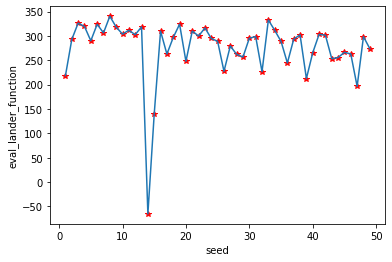

In [90]:
import numpy as np
import matplotlib.pyplot as plt
plt.plot(x, X, 'r*')
plt.plot(x, X)
plt.xlabel("seed")
plt.ylabel("eval_lander_function")
plt.show()

# On écrit une fonction objectif qui calcule la moyenne de la performance pour les seeds allant de 1 à 50. 
Le budget maximum est de 250 évaluations.

In [91]:
def calcul_moyenneP(x):
    def eval_lander_function(x, env, seed=None, render=False, trace=False):
        env.seed(seed)
        total_reward = 0
        steps = 0
        s = env.reset()
        w = x[0:12]
        while True:
            a = heuristic_Controller(s, w)
            s, r, done, info = env.step(a)
            total_reward += r

            if render:
                still_open = env.render()
                if still_open == False: break

            if trace:
                if steps % 20 == 0 or done:
                    print("observations:", " ".join(["{:+0.2f}".format(x) for x in s]))
                print("step {} total_reward {:+0.2f}".format(steps, total_reward))
        
            steps += 1
            if(steps > 250):
                done = True
            if done: break
        return total_reward
    
    X=np.zeros(49)
    x=np.zeros(49)
    for i in range(1,50):
        X[i-1]=eval_lander_function(x=np.array([0.5, 1, 0.4, 0.55, 0.5, 1, 0.5, 0.5, 0, 0.5, 0.05, 0.05]), env=LunarLander(), seed=i,render=False)
        x[i-1]=i
    resultat=np.mean(X)
    return resultat
PM=calcul_moyenneP(x=np.array([0.5, 1, 0.4, 0.55, 0.5, 1, 0.5, 0.5, 0, 0.5, 0.05, 0.05]))
print("La performance moyenne est :", PM )


La performance moyenne est : 242.38500944255122
